In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Step 1. Load dataset**

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Chapter 8/Minerals Identification Dataset/'

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers

In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
from keras.models import Model, load_model

In [ ]:
from tensorflow.keras.models import Sequential

# **Step 2. Visualize the data**

In [ ]:
import matplotlib.pyplot as plt

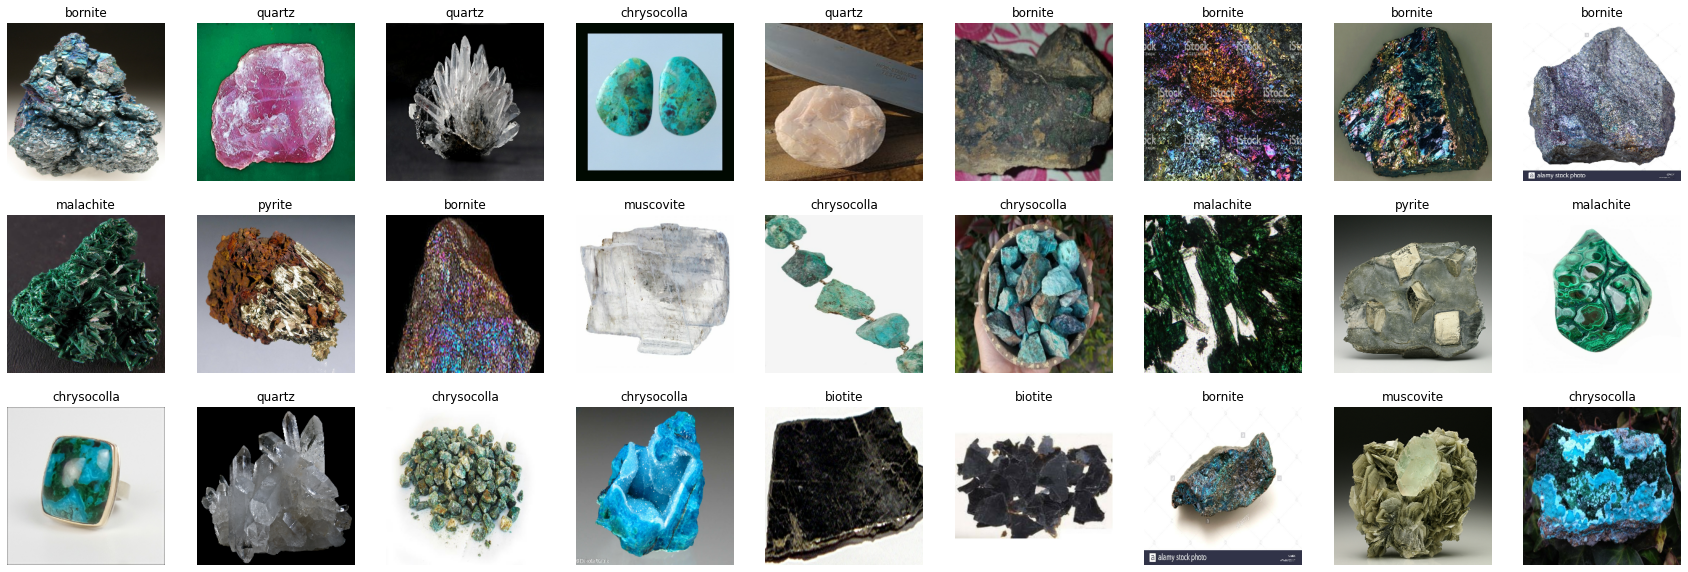

In [ ]:
plt.figure(figsize=(30, 10)) # This line creates a new figure for the plot with a specified size of 30 inches in width and 10 inches in height.
for images, labels in train_ds.take(1): # This line iterates through the first batch (take(1)) of the training dataset (train_ds). Each iteration returns a batch of images and their corresponding labels.
  for i in range(27): # This line starts a loop that iterates 27 times, presumably to display 27 images. The number 27 is chosen arbitrarily and depends on the specific requirements of the visualization.
    ax = plt.subplot(3, 9, i + 1) # This line creates subplots within the main plot. The subplot function takes three arguments: the number of rows (3), the number of columns (9), and the current index (i + 1) for the subplot being created in the loop.
    plt.imshow(images[i].numpy().astype("uint8")) # This line displays the i-th image in the current batch. It uses imshow to show the image, and numpy().astype("uint8") is used to convert the image data to an unsigned 8-bit integer format, which is often expected by the plotting functions.
    plt.title(class_names[labels[i]]) # This line sets the title of the subplot to the corresponding label of the current image. It assumes that there is a list or array called class_names containing the class labels for the dataset.
    plt.axis("off") # This line turns off the axis labels and ticks for the current subplot, making the plot cleaner by removing unnecessary axis information.

# **Step 3. ResNet50**

# **3.1 ImageDataGenerator**

Before we start, because of the type of our dataset, we need to use the ImageDataGenerator tool.

tf.keras.preprocessing.image.ImageDataGenerator Generate batches of tensor image data with real-time data augmentation.

The Keras deep learning library provides the ability to easily use data augmentation and does this automatically and optimally during network training. This functionality is available using the ImageDataGenerator class. First of all, you must create an object from this class and give it the settings of the types and amount of data augmentations through the arguments of the class constructor.

The main advantage of using this class to load data is that the images for a dataset are loaded in batches, meaning it can be used to load both small datasets and very large image datasets with thousands or millions of images. 

Other advantages of using the ImageDataGenerator class are that it can be used to change the automatic comparison of image values and also, and it can automatically generate the completed version of the images.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Now we use the following lines, they are from one of the great examples on the TensorFlow website. 
# For more information please check the references [3].

train_datagen = ImageDataGenerator(
        rescale=1./255, # rescale is the rescaling factor.
        shear_range=0.2, # shear_range it's Shear Intensity and by Shear means the angle in the counter-clockwise direction in degrees.
        zoom_range=0.2, # zoom_range this range is for random zoom.
        horizontal_flip=True) # horizontal_flip must be Boolean and Randomly flip inputs horizontally.
test_datagen = ImageDataGenerator(rescale=1./255)

# [3] https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [ ]:
train_generator = train_datagen.flow_from_directory(
        data_dir, # we put the address of our directory.
        target_size = (256, 256), # target_size this is the dimension to which all found images will be scaled.
        batch_size=32, # batch_size this is the size of the data batches. 
        class_mode='categorical') # class_mode (‘categorical’): it is a 2D NumPy array of one-way encoded labels and supports multi-label output.

Found 961 images belonging to 7 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
        data_dir,
        target_size = (256, 256),
        batch_size=32,
        class_mode='categorical')

Found 961 images belonging to 7 classes.


# **3.2 Identity Block**

In [ ]:
def identity_block(X, f, filters, stage, block): 
# X is the input of shape (m, height, width, channel). f is the shape of the middle CONV's window for the primary path. [filters] is defined as the number of filters in the CONV layers of the primary path. The stage is an integer value and is used to name the layers. Block is a string and is used to name the layers.



    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'


    F1, F2, F3 = filters


    X_shortcut = X


    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    # tf.keras.layers.Conv2D is a 2D convolution layer. Strides it's specifying the strides of the convolution along the height and width and it Can be a single integer to specify the same value for all spatial dimensions. Padding It is either "valid" or "same“. When "same" causes zeros to be equally spaced left/right or top/bottom of the input. "valid" means no padding.
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    # tf.keras.layers.BatchNormalization is a layer that normalizes its inputs. axis this is the integer and the axis that should be normalized.
    X = Activation('relu')(X)
    # Activation This is an activation function to use.


    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    X = Add()([X, X_shortcut]) 
    # Add() is a method to add an element to the set.
    X = Activation('relu')(X)


    return X
    # return this is a method to send the result of the function to the caller.

# **3.3 Convolutional Block**

In [ ]:
# The input size is not the same as the size of the output. 
# In the convolutional block, the input size is not equal to the output size, and a convolution layer is used.

def convolutional_block(X, f, filters, stage, block, s = 2):


    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'


    F1, F2, F3 = filters


    X_shortcut = X



    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)



    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)



    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)



    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)


    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

# **3.4 Creating ResNet50**

In [ ]:
def ResNet50(input_shape=(256, 256, 3), classes=7):



    X_input = Input(input_shape)


    X = ZeroPadding2D((3, 3))(X_input) 
    # tf.keras.layers.ZeroPadding2D it's zero-padding layer for 2D input.


    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(X)
    # tf.keras.layers.Conv2D is a 2D convolution layer. Strides it's specifying the strides of the convolution along the height and width and it Can be a single integer to specify the same value for all spatial dimensions. 
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    # tf.keras.layers.BatchNormalization is a layer that normalizes its inputs. axis this is the integer and the axis that should be normalized.
    X = Activation('relu')(X)
    # Activation This is an activation function to use.
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # tf.keras.layers.MaxPool2D is a maximum pooling operation for 2D spatial data.


    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)



    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')




    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')



# --------------------------------------------------------------------------------------------------------------



    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')


    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')


    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')


    X = AveragePooling2D((2,2), name="avg_pool")(X)
    # tf.keras.layers.AveragePooling2D it's an average pooling operation for spatial data.




    X = Flatten()(X)
    # tf.keras.layers.Flatten it will Flatten the input (and does not affect the batch size).
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    # tf.keras.layers.Dense your regular densely-connected NN layer.



    model_ResNet50 = Model(inputs = X_input, outputs = X, name='ResNet50')
    # tf.keras.Model will groups layers into an object with training and inference features. inputs the input(s) of the model. outputs the output(s) of the model. name the name of the model.

    return model_ResNet50
    # return this is a method to send the result of the function to the caller.


# **3.5 We build our ResNet50 model**

from keras.initializers import glorot_uniform. This is Glorot's uniform initializer, also known as Xavier's uniform initializer. It is a method that generates an initial value from a uniform distribution. We can use Xavier initialization, and this is both in the uniform distribution and the normal distribution. And the main idea behind Xavier initialization is to draw weights from a distribution with zero mean and a certain variance.

In [ ]:
from keras.initializers import glorot_uniform

In [ ]:
model_ResNet50 = ResNet50(input_shape = (256, 256, 3), classes = 7)

# **3.6 Compile the model**


In [ ]:
model_ResNet50.compile(optimizer='adam', # We will define the optimizer as adam's efficient stochastic gradient descent algorithm. This is a popular version of the descent gradient because it adjusts itself automatically and gives good results on a wide variety of problems. It is the Optimizer that implements the Adam algorithm.
              loss='categorical_crossentropy', # When compiling, we need to specify some additional properties needed when training the network. Remember that training a network means finding the best set of weights to map inputs to outputs in our data set. We need to define a loss function to be used to evaluate a set of weights. It calculates the cross-entropy loss between the labels and predictions.
              metrics=['accuracy']) # The optimizer is used to search across different network weights and any optional metrics we want to collect and report during training. Finally, since it is a classification problem, we collect and report the classification accuracy defined through metric reasoning. Calculates how often the predictions equal the label.

# **3.7 We obtain our model summary (ResNet50)**

In [ ]:
model_ResNet50.summary()
# model.summary() This prints a summary of our model information.

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_5 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 128, 64  9472        ['zero_padding2d_5[0][0]']       
                                )                                                          

# **3.8 Train the model**

In [ ]:
history = model_ResNet50.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=20
)

# We have defined our model and prepared it for efficient calculation. 
# Now it's time to run the model on some data. We can train or fit our model on our loaded data by calling the fit() function. 
# Training occurs in different periods and each period is divided into several categories. 

# A period consists of one or more batches, based on the batch size selected and the model suitable for many periods. 
# The training process is performed for a specified number of iterations through a dataset called epochs, which we must specify using the epochs argument. 
# In short, it is an integer and its number of cycles to train the model.

# These settings can be chosen experimentally using trial and error.  
# We want to train the model enough so that it can learn good (or good enough) mappings from input data sets to output classifications. 
# The model always has some errors, but the amount of error decreases after some time for a given model configuration. 
# This method is called model convergence.

# validation_data this is the data based on which the loss and each criterion of the model are evaluated at the end of each period, and the model is not trained on this data.

# steps_per_epoch & validation_steps we put our desired numbers

Epoch 1/15
25/25 [==============================] - 808s 32s/step - loss: 2.8449 - accuracy: 0.3953 - val_loss: 2.4699 - val_accuracy: 0.2458
Epoch 2/15
25/25 [==============================] - 831s 33s/step - loss: 2.7297 - accuracy: 0.4369 - val_loss: 3.8806 - val_accuracy: 0.0938
Epoch 3/15
25/25 [==============================] - 811s 33s/step - loss: 2.1553 - accuracy: 0.4499 - val_loss: 4.9898 - val_accuracy: 0.1292
Epoch 4/15
25/25 [==============================] - 801s 32s/step - loss: 1.9416 - accuracy: 0.5202 - val_loss: 2.3248 - val_accuracy: 0.3229
Epoch 5/15
25/25 [==============================] - 806s 32s/step - loss: 2.1494 - accuracy: 0.4902 - val_loss: 2.0050 - val_accuracy: 0.3021
Epoch 6/15
25/25 [==============================] - 810s 33s/step - loss: 2.0586 - accuracy: 0.5215 - val_loss: 2.4119 - val_accuracy: 0.3958
Epoch 7/15
25/25 [==============================] - 796s 32s/step - loss: 1.3529 - accuracy: 0.6307 - val_loss: 1.5772 - val_accuracy: 0.5083
Epoch 

# **Step 4. VGG16**

# **4.1 Creating VGG16**

In [ ]:
def VGG16(input_shape=(224, 224, 3), classes=7):

  X_input = Input(input_shape)

  X = ZeroPadding2D((3, 3))(X_input)
  # tf.keras.layers.ZeroPadding2D it's zero-padding layer for 2D input.

  X = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1-1')(X)
  # tf.keras.layers.Conv2D is a 2D convolution layer. filters it's the dimensionality of the output space. kernel_size specifies the height and width of the 2D convolution window and can be an integer to specify a value for all spatial dimensions. Padding It is either "valid" or "same“. When "same" causes zeros to be equally spaced left/right or top/bottom of the input. Activation This is an activation function to use.
  X = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1-2')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  # tf.keras.layers.MaxPool2D is a maximum pooling operation for 2D spatial data.

  X = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2-1')(X)
  X = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2-2')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-1')(X)
  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-2')(X)
  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-3')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-1')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-2')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-3')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-1')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-2')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-3')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = AveragePooling2D((2,2), name="avg_pool")(X)
  # tf.keras.layers.AveragePooling2D it's an average pooling operation for spatial data.

  X = Flatten()(X)
  # tf.keras.layers.Flatten it will Flatten the input (and does not affect the batch size).

  X = Dense(classes, activation='softmax', name='fc-1' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  # tf.keras.layers.Dense your regular densely-connected NN layer.
  X = Dense(classes, activation='softmax', name='fc-2' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  X = Dense(classes, activation='softmax', name='fc-3' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

  model_VGG16 = Model(inputs = X_input, outputs = X, name='VGG16')
  # tf.keras.Model will groups layers into an object with training and inference features. inputs the input(s) of the model. outputs the output(s) of the model. name the name of the model.

  return model_VGG16
  # return this is a method to send the result of the function to the caller.

# **4.2 We build our VGG16 model**

In [ ]:
from keras.initializers import glorot_uniform

In [ ]:
model_VGG16 = VGG16(input_shape = (224, 224, 3), classes = 7)

# **4.3 Compile the model**


In [ ]:
model_VGG16.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **4.4 We obtain our model summary (VGG16)**

In [ ]:
model_VGG16.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 230, 230, 3)      0         
 ng2D)                                                           
                                                                 
 conv1-1 (Conv2D)            (None, 230, 230, 64)      1792      
                                                                 
 conv1-2 (Conv2D)            (None, 230, 230, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 114, 114, 64)     0         
 g2D)                                                            
                                                                 
 conv2-1 (Conv2D)            (None, 114, 114, 128)     73856 

# **4.5 Train the model**

In [ ]:
history = model_VGG16.fit(
    train_generator,
    steps_per_epoch=15,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=10
)

Epoch 1/5
15/15 [==============================] - 1401s 94s/step - loss: 1.9438 - accuracy: 0.2396 - val_loss: 1.9381 - val_accuracy: 0.2688
Epoch 2/5
15/15 [==============================] - 1309s 88s/step - loss: 1.9419 - accuracy: 0.2183 - val_loss: 1.9354 - val_accuracy: 0.2531
Epoch 3/5
15/15 [==============================] - 1382s 93s/step - loss: 1.9420 - accuracy: 0.2208 - val_loss: 1.9409 - val_accuracy: 0.2313
Epoch 4/5
15/15 [==============================] - 1388s 93s/step - loss: 1.9296 - accuracy: 0.2417 - val_loss: 1.9229 - val_accuracy: 0.2250
Epoch 5/5
15/15 [==============================] - 1387s 93s/step - loss: 1.9181 - accuracy: 0.2479 - val_loss: 1.9085 - val_accuracy: 0.2688


# **Step 5. VGG19**

# **5.1 Creating VGG19**

In [ ]:
def VGG19(input_shape=(224, 224, 3), classes=22):

  X_input = Input(input_shape)

  X = ZeroPadding2D((3, 3))(X_input)

  X = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1-1')(X)
  X = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv1-2')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2-1')(X)
  X = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv2-2')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-1')(X)
  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-2')(X)
  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-3')(X)
  X = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv3-4')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-1')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-2')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-3')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv4-4')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-1')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-2')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-3')(X)
  X = Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='conv5-4')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  X = AveragePooling2D((2,2), name="avg_pool")(X)

  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc-1' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  X = Dense(classes, activation='softmax', name='fc-2' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
  X = Dense(classes, activation='softmax', name='fc-3' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

  model_VGG19 = Model(inputs = X_input, outputs = X, name='VGG19')

  return model_VGG19

# **5.2 We build our VGG19 model**

In [ ]:
from keras.initializers import glorot_uniform

In [ ]:
model_VGG19 = VGG19(input_shape = (224, 224, 3), classes = 22)

# **5.3 Compile the model**


In [ ]:
model_VGG19.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# **5.4 We obtain our model summary (VGG19)**

In [ ]:
model_VGG19.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 230, 230, 3)      0         
 2D)                                                             
                                                                 
 conv1-1 (Conv2D)            (None, 230, 230, 64)      1792      
                                                                 
 conv1-2 (Conv2D)            (None, 230, 230, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 114, 114, 64)     0         
 )                                                               
                                                                 
 conv2-1 (Conv2D)            (None, 114, 114, 128)     73856 

# **5.5 Train the model**

In [ ]:
history = model_VGG19.fit(
    train_generator,
    steps_per_epoch = 15,
    epochs = 5,
    validation_data=validation_generator,
    validation_steps = 10
)

Epoch 1/5
15/15 [==============================] - 3477s 233s/step - loss: 3.0672 - accuracy: 0.0823 - val_loss: 3.0581 - val_accuracy: 0.0828
Epoch 2/5
15/15 [==============================] - 3493s 235s/step - loss: 3.0509 - accuracy: 0.1010 - val_loss: 3.0437 - val_accuracy: 0.0875
Epoch 3/5
15/15 [==============================] - 3512s 235s/step - loss: 3.0392 - accuracy: 0.0844 - val_loss: 3.0296 - val_accuracy: 0.0750
Epoch 4/5
15/15 [==============================] - 3487s 234s/step - loss: 3.0199 - accuracy: 0.0854 - val_loss: 3.0173 - val_accuracy: 0.0859
Epoch 5/5
15/15 [==============================] - 3525s 236s/step - loss: 3.0060 - accuracy: 0.0844 - val_loss: 3.0006 - val_accuracy: 0.0859
